<h1>Facial Keypoints Detection<span class="tocSkip"></span></h1>
    
    a simple Convolutional Deep Neural Network model
    for detecting facial keypoints,
    such as location of location of eye brows, eyes, nose, and mouth.
    
Link: https://www.kaggle.com/c/facial-keypoints-detection

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Resource-Monitor" data-toc-modified-id="Resource-Monitor-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resource Monitor</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#import" data-toc-modified-id="import-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>import</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Training-&amp;-Validaiton-Dataset-SPLIT" data-toc-modified-id="Training-&amp;-Validaiton-Dataset-SPLIT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training &amp; Validaiton Dataset SPLIT</a></span></li><li><span><a href="#Training-Dataset-Standardization" data-toc-modified-id="Training-Dataset-Standardization-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Training Dataset Standardization</a></span><ul class="toc-item"><li><span><a href="#standardization-Result" data-toc-modified-id="standardization-Result-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>standardization Result</a></span></li></ul></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#KERAS-import" data-toc-modified-id="KERAS-import-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>KERAS import</a></span></li><li><span><a href="#GPU-availability-check" data-toc-modified-id="GPU-availability-check-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>GPU availability check</a></span></li><li><span><a href="#Construct-MODEL" data-toc-modified-id="Construct-MODEL-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Construct MODEL</a></span></li><li><span><a href="#MODEL-summary" data-toc-modified-id="MODEL-summary-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>MODEL summary</a></span></li><li><span><a href="#TRAIN-ze-model" data-toc-modified-id="TRAIN-ze-model-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>TRAIN ze model</a></span></li></ul></li><li><span><a href="#Training-Result" data-toc-modified-id="Training-Result-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training Result</a></span><ul class="toc-item"><li><span><a href="#sample-indexing-w/-difference" data-toc-modified-id="sample-indexing-w/-difference-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>sample indexing w/ difference</a></span></li></ul></li><li><span><a href="#Create-Submission" data-toc-modified-id="Create-Submission-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create Submission</a></span></li><li><span><a href="#ASSESSMENT" data-toc-modified-id="ASSESSMENT-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ASSESSMENT</a></span></li></ul></div>

# Resource Monitor

CPUMon

download: https://www.downloadcrew.com/article/35114-cpumon

    very simple lightweight graphical CPU monitor.
    Good for keeping CPU and memory in check,
    especially if training dataset is ridiculously big.
    Standalone, no installation.
    
GPU-Z

download: https://www.techpowerup.com/download/techpowerup-gpu-z/

    also simple and lightweight, monitors GPU sensors.
    Good for keeping track of GPU usuage, especially memory,
    considering GPU memory is rather small.
    Standalone, no installation.
    *** Tensorflow tends to allocate all the GPU memory,
    unless otherwise directed, and there's no other way to
    free the GPU memory until the python kernel is killed ***
    

In [1]:
import os

os.startfile(r'C:\STUDY\resource_monitor\CPUMon.exe')
os.startfile(r'C:\STUDY\resource_monitor\GPU-Z.exe')

# Data

## import

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data Processing

In [3]:
df = pd.read_csv('../data/face/training.csv')
# it's a shame, but for now, drop all null
df.dropna(inplace=True)
df.shape

(2140, 31)

In [4]:
# using parallel processing
# 10 threads
# to separate "image" section into var x
from joblib import Parallel, delayed

def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

# ref: https://joblib.readthedocs.io/en/latest/parallel.html
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    x = ex(delayed(format_img)(e) for e in df.Image)
    
x = np.stack(x)[..., None]
x.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:    6.0s finished


(2140, 96, 96, 1)

In [5]:
y = df.iloc[:, :-1].values
y.shape

(2140, 30)

In [6]:
# uses matplotlib to graph picture based on "image" data
def show(x, y=None):
    plt.imshow(x[..., 0], "gray")
    # plots y (label) data on top
    if y is not None:
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color='yellow')
        
    plt.axis('off')

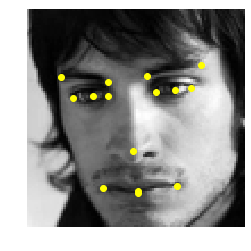

In [7]:
sample_idx = np.random.choice(len(x))    
show(x[sample_idx], y[sample_idx])

## Training & Validaiton Dataset SPLIT

In [8]:
# separate training dataset, validation dataset
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
# x data train set, x data validation set
x_train.shape, x_val.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

In [10]:
# y data train set, y data validation set
y_train.shape, y_val.shape

((1712, 30), (428, 30))

## Training Dataset Standardization

refer to: https://maristie.com/blog/differences-between-normalization-standardization-and-regularization/

In [11]:
# x datasets reshaping for standardization
x_train_norm=x_train[:,:,:,:]
x_val_norm=x_val[:,:,:,:]
x_train_norm=x_train_norm.reshape([1712,96*96,1])
x_val_norm=x_val_norm.reshape([428,96*96,1])

In [12]:
# prepare for standardization
mu=x_train_norm.mean()
sigma=x_train_norm.std()
mu, sigma

(121.83461982513143, 59.23303696478942)

In [13]:
# standardize
x_train_norm=(x_train_norm - mu)/sigma
x_val_norm=(x_val_norm - mu)/sigma

In [14]:
# x training dataset shape, mean, std
x_train_norm.shape, x_train_norm.mean(), x_train_norm.std()

((1712, 9216, 1), -9.338324506192905e-18, 0.9999999999999999)

In [15]:
# x validation dataset shape, mean, std
x_val_norm.shape, x_val_norm.mean(), x_val_norm.std()

((428, 9216, 1), -0.06512222683585148, 0.9844637045228576)

In [16]:
# reshaping x datasets
x_train_norm=x_train_norm.reshape([1712,96,96,1])
x_val_norm=x_val_norm.reshape([428,96,96,1])

x_train_norm.shape, x_val_norm.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

### standardization Result

In [17]:
print("{} is normalized to {}".format(x_train[0][0][0][0], x_train_norm[0][0][0][0]))
print("{} is normalized to {}".format(x_train[0][0][90][0], x_train_norm[0][0][90][0]))

125 is normalized to 0.053439437467138605
91 is normalized to -0.5205645600015546


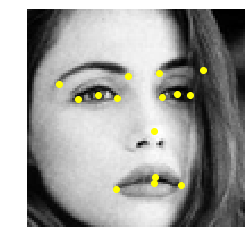

In [18]:
# checking if standardization worked properly
# show img of standardized x_train dataset
sample_idx = np.random.choice(len(x_train_norm))
show(x_train_norm[sample_idx], y_train[sample_idx])

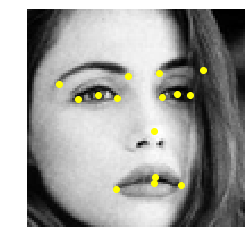

In [19]:
# there shouldn't be any difference
# show img of raw x_train dataset
show(x_train[sample_idx], y_train[sample_idx])

# Model

BATCH NORMALIZATION:

https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/


Conv2d:

https://www.programcreek.com/python/example/89658/keras.layers.Conv2D

## KERAS import

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras.callbacks import CSVLogger

Using TensorFlow backend.


## GPU availability check

In [21]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 864822375671324341
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 561803264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3825372713763913196
physical_device_desc: "device: 0, name: GeForce GT 720, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


## Construct MODEL

In [23]:
model = Sequential([
    Conv2D(72,4,input_shape=(96,96,1),
           activation='relu',
           kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(0.01)),
    AvgPool2D(pool_size=(2,2)),
    Conv2D(48,2,activation='relu',
           use_bias=False,
           kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(48,activation='relu', 
          use_bias = True,
          bias_initializer='he_normal',
          bias_regularizer=regularizers.l2(0.01),
          kernel_initializer='he_normal', 
          kernel_regularizer=regularizers.l2(0.01)),
    Dense(30, activation='relu',
          use_bias = True,
          bias_initializer='he_normal',
          bias_regularizer=regularizers.l2(0.01),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.01))
])

model.compile(optimizer=Adam(0.001),loss='mse',metrics=['mae'])

## MODEL summary
    KERAS provides convenient tools to check
    what the model looks like. Refer to below;

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 93, 72)        1224      
_________________________________________________________________
average_pooling2d_1 (Average (None, 46, 46, 72)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 48)        13824     
_________________________________________________________________
batch_normalization_1 (Batch (None, 45, 45, 48)        192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 97200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 97200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4665648   
__________

In [25]:
model.input, model.output

(<tf.Tensor 'conv2d_1_input:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'dense_2/Relu:0' shape=(?, 30) dtype=float32>)

## TRAIN ze model

In order to stabilize activation function ReLu,

reduce Learning Rate per n epochs.

https://keras.io/callbacks/#reducelronplateau

    current learning rate is 0.01
    if loss is not consistent,
    it will be reduced by factor of 0.2,
    at every 5 epoch,
    until minimum learning rate 0.001 is reached

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                      patience=5, min_lr=0.0001)

# 100 epochs is most preferrable
# by making an instance of model.fit(),
# we can make analysis of the training process.
log = model.fit(x_train_norm, 
                y_train, 
                epochs = 100,
                batch_size = 10,
                validation_data=[x_val_norm, y_val],
                callbacks=[reduce_lr])

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 31s 18ms/step - loss: 420.4969 - mean_absolute_error: 14.0585 - val_loss: 253.4816 - val_mean_absolute_error: 12.4512
Epoch 2/100
1712/1712 [==============================] - 29s 17ms/step - loss: 94.6464 - mean_absolute_error: 5.8609 - val_loss: 210.5274 - val_mean_absolute_error: 11.7668
Epoch 3/100
1712/1712 [==============================] - 29s 17ms/step - loss: 75.8220 - mean_absolute_error: 4.5617 - val_loss: 119.5326 - val_mean_absolute_error: 7.9724
Epoch 4/100
1712/1712 [==============================] - 28s 16ms/step - loss: 69.8097 - mean_absolute_error: 4.0700 - val_loss: 72.7896 - val_mean_absolute_error: 4.4403
Epoch 5/100
1712/1712 [==============================] - 28s 16ms/step - loss: 67.0345 - mean_absolute_error: 3.8008 - val_loss: 74.3394 - val_mean_absolute_error: 4.6258
Epoch 6/100
1712/1712 [==============================] - 28s 16ms/step - loss: 65.1966 - me

1712/1712 [==============================] - 28s 16ms/step - loss: 53.0177 - mean_absolute_error: 2.2784 - val_loss: 54.2072 - val_mean_absolute_error: 2.4286
Epoch 49/100
1712/1712 [==============================] - 28s 16ms/step - loss: 52.7246 - mean_absolute_error: 2.2358 - val_loss: 54.1226 - val_mean_absolute_error: 2.4458
Epoch 50/100
1712/1712 [==============================] - 28s 16ms/step - loss: 52.5705 - mean_absolute_error: 2.2320 - val_loss: 53.9342 - val_mean_absolute_error: 2.4213
Epoch 51/100
1712/1712 [==============================] - 28s 17ms/step - loss: 52.3900 - mean_absolute_error: 2.2061 - val_loss: 53.8683 - val_mean_absolute_error: 2.4259
Epoch 52/100
1712/1712 [==============================] - 29s 17ms/step - loss: 52.2686 - mean_absolute_error: 2.1918 - val_loss: 53.7294 - val_mean_absolute_error: 2.4184
Epoch 53/100
1712/1712 [==============================] - 29s 17ms/step - loss: 52.1108 - mean_absolute_error: 2.1664 - val_loss: 54.0228 - val_mean_abso

Epoch 96/100
1712/1712 [==============================] - 28s 16ms/step - loss: 50.4606 - mean_absolute_error: 1.9511 - val_loss: 52.3642 - val_mean_absolute_error: 2.3153
Epoch 97/100
1712/1712 [==============================] - 28s 16ms/step - loss: 28.3968 - mean_absolute_error: 1.4417 - val_loss: 4.3654 - val_mean_absolute_error: 1.0866
Epoch 98/100
1712/1712 [==============================] - 28s 16ms/step - loss: 2.5433 - mean_absolute_error: 0.7403 - val_loss: 4.3335 - val_mean_absolute_error: 1.1404
Epoch 99/100
1712/1712 [==============================] - 28s 17ms/step - loss: 2.2931 - mean_absolute_error: 0.7150 - val_loss: 3.9192 - val_mean_absolute_error: 1.0629
Epoch 100/100
1712/1712 [==============================] - 29s 17ms/step - loss: 2.2057 - mean_absolute_error: 0.7170 - val_loss: 3.9442 - val_mean_absolute_error: 1.1033


# Training Result

In [27]:
print(f'MAE final: {model.evaluate(x_val, y_val)[1]}')
print(f'MAE final: {model.evaluate(x_val_norm, y_val)[1]}')

428/428 [==============================] - 2s 4ms/step
MAE final: 29.809575998894523
428/428 [==============================] - 1s 3ms/step
MAE final: 1.103289385265279


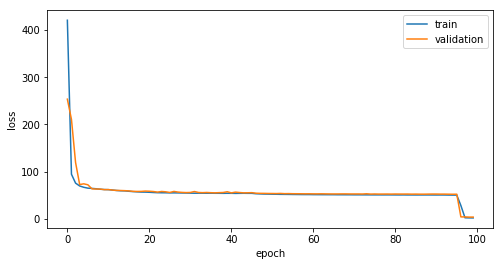

In [29]:
# graphing the training loss and validation loss
# is useful to visually check for
# overfitting/overshotting,
# or any anomaly.
def show_results(log):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(log['loss'], label='train')
    ax.plot(log['val_loss'], label='validation')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss')
    ax.legend()
    
log = log.history
show_results(log)

## sample indexing w/ difference
Mean Absolute Value:

https://www.geogebra.org/m/UaMEvgyH

In [30]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(5,5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

In [31]:
# calculate the difference,
# between predicted value and real value
predicted_val=model.predict(x_val_norm)
residual_val=np.abs(predicted_val - y_val)
# MAD ==> Mean Absolute Value
# 30 ==> number of labels(x+y)
# not sure why y_val is treated as mean?
mad_val=np.sum(residual_val, axis=1)/30

# indices == index
# sort by the difference
# between predicted value and real value
indices=mad_val.argsort()
indices.shape

(428,)

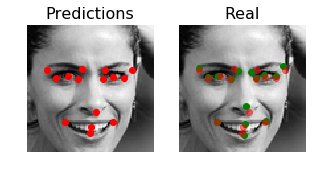

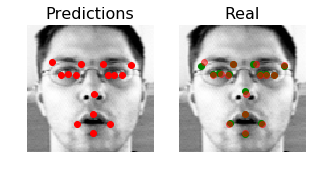

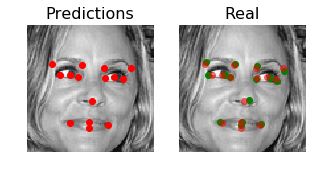

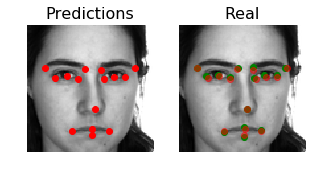

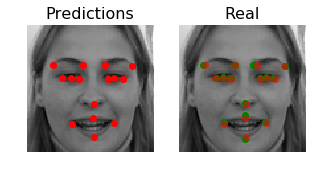

In [32]:
# Random Sample comparison
for _ in range(5):
    index = np.random.choice(x_val_norm.shape[0])
    sample_x = x_val_norm[index, None]
    sample_y = y_val[index, None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

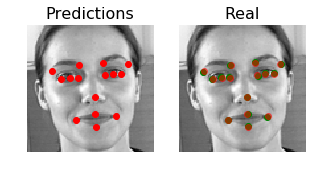

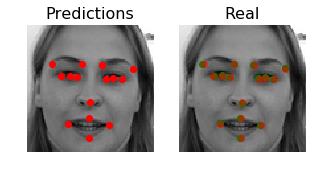

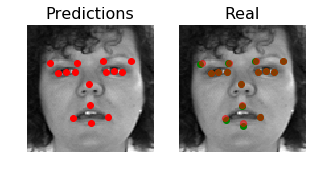

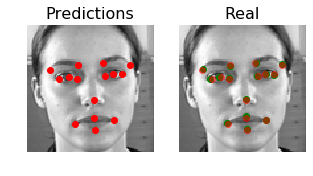

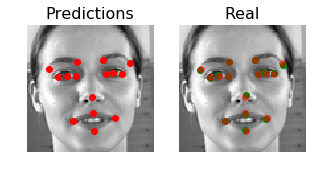

In [33]:
# Most Alike
for i in range(5):
    sample_x = x_val_norm[indices[i], None]
    sample_y = y_val[indices[i], None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

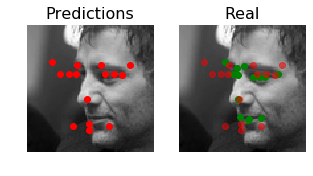

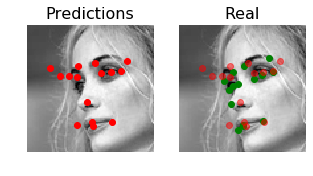

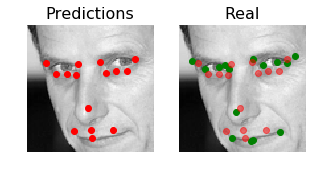

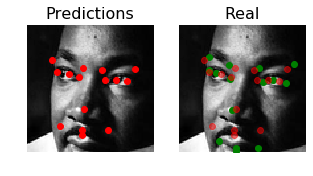

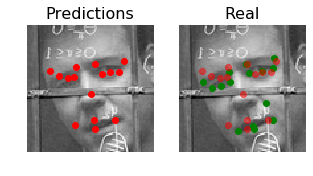

In [34]:
# Least Alike
# it's obvious that side-face pics are the worst
for i in [-1,-2,-3,-4,-5]:
    sample_x = x_val_norm[indices[i], None]
    sample_y = y_val[indices[i], None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

# Create Submission

In [35]:
Test_Dir = '../data/face/test.csv'
lookid_dir = '../data/face/IdLookupTable.csv'
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)

In [36]:
# get image section of test data
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    X_test = ex(delayed(format_img)(e) for e in test_data.Image)
    
X_test = np.stack(X_test)[..., None]
X_test.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:    4.9s finished


(1783, 96, 96, 1)

In [37]:
# standardize test dataset
X_test_norm=X_test[:,:,:,:]
X_test_norm=X_test_norm.reshape([1783,96*96,1])
# mu=x_train_norm.mean()
# sigma=x_train_norm.std()
X_test_norm=(X_test_norm - mu)/sigma
X_test_norm=X_test_norm.reshape([1783,96,96,1])

In [38]:
# make prediction
pred = model.predict(X_test_norm)

In [40]:
# this submission requires looking up
# IdLookUpTable provided by Kaggle
# every 30 rows (rowId) are considered one image
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)
rowid=list(lookid_data['RowId'])

# index of each feature is extracted
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

# as per imageID and feature index,
# values from predction is extracted,
# and appended to a list 'preded'
# pred[0][0] ==> ~66 ==> 1st image, 1st feature(left eye center x)
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

# rowid converted to dataframe
rowid = pd.Series(rowid, name = 'RowId')
# features converted to dataframe
loc = pd.Series(preded, name = 'Location')
# rowid, and loc dataframes are concated
submission = pd.concat([rowid,loc],axis = 1)

In [ ]:
# save submission file
submission.to_csv('../data/predictions/face_9_cb_bias.csv',index = False)

In [41]:
submission.head()

,RowId,Location
0,1,65.246803
1,2,37.607620
2,3,30.002489
3,4,36.501545
4,5,59.852516


# ASSESSMENT

![face_9_result](https://user-images.githubusercontent.com/44990492/56116789-a985c380-5fa1-11e9-939f-f2756dc09a7b.png)

    note: 3 dense network did 4.1
    adding CNN + Normalization + CALLBACK improved it to 3.8
    adding BIAS improved it to 3.1
    
    face_7 (w/o bias):
        loss: 6.3249 - mean_absolute_error: 1.7404
        val_loss: 6.9588 - val_mean_absolute_error: 1.8378
        
    face_8 (w bias):
        loss: 1.8949 - mean_absolute_error: 0.6170
        val_loss: 3.7994 - val_mean_absolute_error: 1.0542
        

![face_7_loss_graph](https://user-images.githubusercontent.com/44990492/56116942-fd90a800-5fa1-11e9-88ea-3c4fda0646dc.png)

![face_8_loss_graph](https://user-images.githubusercontent.com/44990492/56116945-fd90a800-5fa1-11e9-8dda-59f954bf73dc.png)

![face_9_loss_graph](https://user-images.githubusercontent.com/44990492/56116946-fd90a800-5fa1-11e9-9cd9-157236bad03c.png)

    It seems adding bias does stablize the loss (activation function).
    Model with bias have comparably lower loss - although the cause
    could be the random weight value;
    graph does show that model without bias started above 400.